In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import ElasticNet,ElasticNetCV,Lasso,Ridge
import xgboost
from sklearn.preprocessing import LabelEncoder,RobustScaler

In [3]:
train=pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
train_id=train['Id']
test_id=test['Id']
train.drop('Id',1,inplace=True)
test.drop('Id',1,inplace=True)

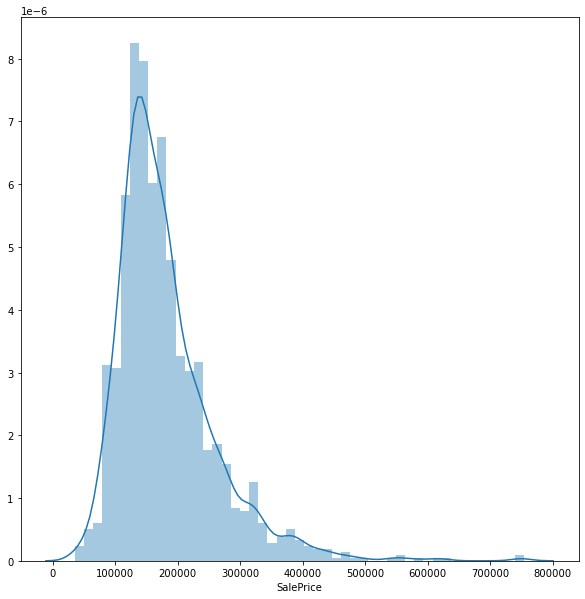

In [5]:
plt.figure(figsize=(10,10))
sns.distplot(train['SalePrice'])

In [6]:
train['SalePrice']=np.log1p(train['SalePrice'])

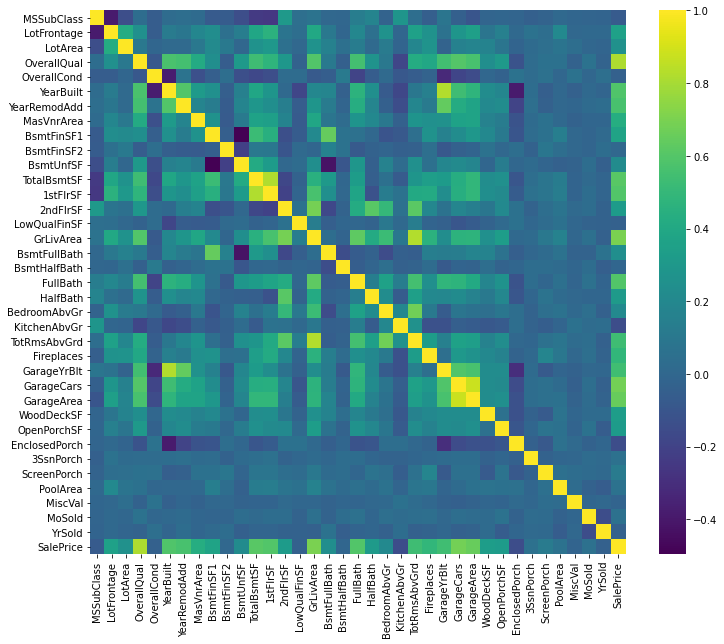

In [7]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(),cmap='viridis')

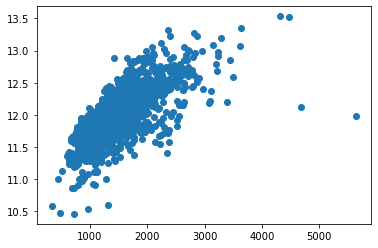

In [8]:
plt.scatter(x=train['GrLivArea'],y=train['SalePrice'])
sns.set()

In [9]:
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<12.5)].index)

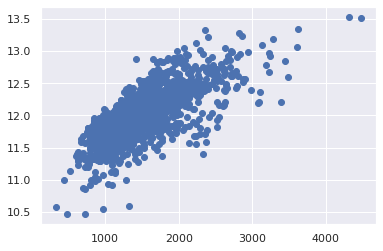

In [10]:
plt.scatter(train['GrLivArea'],train['SalePrice'])

In [11]:
y_train=train['SalePrice'].values
train_index=len(train)
test_index=len(test)
df=pd.concat([train,test]).reset_index(drop=True)

In [12]:
df.shape

(2917, 80)

In [13]:
df.drop('SalePrice',1,inplace=True)

In [14]:
missing=df.isnull().sum()/len(df)*100

In [15]:
missing=pd.DataFrame(missing.sort_values(ascending=False))

In [16]:
missing.head(20)

,0
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageCond,5.450806
GarageQual,5.450806
GarageYrBlt,5.450806
GarageFinish,5.450806


In [17]:
for col in ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']:
    df[col]=df[col].fillna('None')

In [18]:
df['LotFrontage']=df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [19]:
for col in ['GarageQual','GarageCond','GarageType','GarageFinish']:
    df[col]=df[col].fillna('None')

In [20]:
for col in ['GarageYrBlt','GarageArea','GarageCars']:
    df[col]=df[col].fillna(0)

In [21]:
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    df[col]=df[col].fillna(0)

In [22]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col]=df[col].fillna('None')

In [23]:
df["MasVnrType"] =df["MasVnrType"].fillna("None")
df["MasVnrArea"] =df["MasVnrArea"].fillna(0)

In [24]:
df['MSZoning'] =df['MSZoning'].fillna(df['MSZoning'].mode()[0])

In [25]:
missing.columns=['Value']

In [26]:
missing[missing['Value']>0]

,Value
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageCond,5.450806
GarageQual,5.450806
GarageYrBlt,5.450806
GarageFinish,5.450806


In [27]:
df =df.drop(['Utilities'], axis=1)

In [28]:
df['Functional']=df['Functional'].fillna('Typ')

In [29]:
df['Electrical'] =df['Electrical'].fillna(df['Electrical'].mode()[0])

In [30]:
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])

In [31]:
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

In [32]:
df['SaleType'] =df['SaleType'].fillna(df['SaleType'].mode()[0])
df['MSSubClass'] =df['MSSubClass'].fillna("None")


In [33]:
missing=df.isnull().sum()/len(df)*100
missing=pd.DataFrame(missing.sort_values(ascending=False),columns=['Value'])

In [34]:
missing[missing['Value']>0]

,Value


In [35]:
df['YrSold'].value_counts()

2007    691
2009    647
2008    621
2006    619
2010    339
Name: YrSold, dtype: int64

In [36]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for col in cols:
    ll=LabelEncoder()
    ll.fit(list(df[col].values))
    df[col]=ll.transform(list(df[col].values))

In [37]:
df.shape

(2917, 78)

In [38]:
df['Total']=df['TotalBsmtSF']+df['1stFlrSF']+df['2ndFlrSF']

In [39]:
numerical_col=df.dtypes[df.dtypes!='object'].index

In [40]:
skew=pd.DataFrame(df[numerical_col].apply(lambda x: x.skew()).sort_values(ascending=False),columns=['Skew'])

In [41]:
skew=skew[skew['Skew']>0.75]

In [42]:
from scipy.special import boxcox1p

In [43]:
skew_features=skew.index

In [44]:
lam=0.15
for c in skew_features:
    df[c]=boxcox1p(df[c],lam)

In [45]:
skew=pd.DataFrame(df[numerical_col].apply(lambda x: x.skew()).sort_values(ascending=False),columns=['Skew'])

In [46]:
skew

,Skew
PoolArea,15.767638
3SsnPorch,8.926241
LowQualFinSF,8.745528
MiscVal,5.597842
LandSlope,4.532595
BsmtHalfBath,3.788634
KitchenAbvGr,3.699206
ScreenPorch,2.978584
BsmtFinSF2,2.564554
EnclosedPorch,2.025363


In [47]:
df=pd.get_dummies(df)

In [48]:
df.shape

(2917, 220)

In [49]:
train=df[:train_index]
test=df[train_index:]

In [50]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [51]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [52]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [53]:
len(train)

1458

In [54]:
len(y_train)

1458

In [55]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1104 (0.0068)



In [56]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [57]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [58]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [59]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [60]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

KeyboardInterrupt: 

In [61]:
model_xgb.fit(train.values,y_train)

[11:23:25] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
pred=np.expm1(model_xgb.predict(test.values))

In [63]:
sub=pd.DataFrame()
sub['Id']=test_id
sub['SalePrice']=pred

In [64]:
sub.to_csv('fi.csv',index=False)